## Gradient Boosting

**Gradient Boosting**  
- Gradient Boosting builds an **ensemble of decision trees** sequentially.  
- Each new tree is trained to **correct the errors (residuals)** of the previous ones.  
- The model combines many weak learners (shallow trees) into a strong predictor.  

**Why?**  
- Captures **non-linear relationships** and **feature interactions** more effectively than Logistic Regression.  
- More **flexible and accurate** than Random Forest because it focuses on the hardest cases iteratively.  
- Usually achieves higher **ROC-AUC, PR-AUC, and F1** on imbalanced datasets.

- The dataset is **imbalanced (~6% positives)** and simple models struggle with recall.  
- Gradient Boosting improves both **ranking quality** (AUCs) and the **precision–recall balance**.  
- It consistently gave the **best performance** among the models tested, making it our final choice.


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from scripts.data_loader import load_caravan
from scripts.metrics import evaluate_model
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform
random.seed(42)
np.random.seed(42)

In [2]:
train, test, X, y, TARGET = load_caravan(data_dir="../data")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

In [3]:
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting stages
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Learning rate shrinks the contribution of each tree
    'max_depth': np.arange(3, 15, 2),  # Maximum depth of the individual trees
    'min_samples_split': np.arange(2, 20, 2),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 20, 2),  # Minimum number of samples required to be at a leaf node
    'subsample': np.linspace(0.6, 1.0, 5),  # Fraction of samples used for fitting individual base learners
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,                  
    scoring='average_precision',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gb_search.fit(X_train, y_train)
print("Best GB params:", gb_search.best_params_)
print("Best CV PR-AUC:", round(gb_search.best_score_, 4))

gb_best = gb_search.best_estimator_

proba_val = gb_best.predict_proba(X_val)[:, 1]
preds_val = (proba_val >= 0.5).astype(int)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GB params: {'subsample': np.float64(1.0), 'n_estimators': np.int64(200), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(7), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.01)}
Best CV PR-AUC: 0.1914


In [4]:
results = evaluate_model("Gradient Boosting (tuned) ", y_val, proba_val)


=== Gradient Boosting (tuned)  ===
ROC-AUC: 0.7927 | PR-AUC: 0.2161
Best-F1 threshold: 0.106
At best-F1: Precision=0.234, Recall=0.500, F1=0.319
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1643
           1       0.23      0.50      0.32       104

    accuracy                           0.87      1747
   macro avg       0.60      0.70      0.62      1747
weighted avg       0.92      0.87      0.89      1747



At best-F1 threshold, it identify buyers with 23% precision and 50% recall (F1 = 0.31). This threshold balances missing buyers (recall) against contacting uninterested customers (precision).

Although F1 = 0.31 looks small, in an imbalanced dataset where only 6% are positives, this is a large lift compared to baseline (≈0.1). It means the model is 3× more effective at finding real buyers than chance. For business, this translates to much more efficient targeting.

In [5]:
# Refit tuned GB on ALL labeled training data
gb_final = type(gb_best)(**gb_best.get_params())
gb_final.random_state = 42
gb_final.fit(X, y)

GradientBoostingClassifier(learning_rate=np.float64(0.01),
                           max_depth=np.int64(3), min_samples_leaf=np.int64(7),
                           min_samples_split=np.int64(8),
                           n_estimators=np.int64(200), random_state=42,
                           subsample=np.float64(1.0))

In [6]:
X_test = test.copy()
best_thr = 0.106

test_probabilities = gb_final.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

test_pred = (test_probabilities >= best_thr).astype(int)

# count and percentage
num_pred = int(test_pred.sum())
total = len(test_pred)
pct = 100.0 * num_pred / total

print(f"Number of customers predicted to be interested: {num_pred}")
print(f"Percentage of customers predicted to be interested: {pct:.2f}%")

Number of customers predicted to be interested: 444
Percentage of customers predicted to be interested: 11.10%


Top 10 Features Influencing Decisions:
                       Feature  Importance
46   Contribution car policies    0.315636
58  Contribution fire policies    0.146166
60  Contribution boat policies    0.086718
17       Lower level education    0.066335
81          # of boat policies    0.047795
0             Customer Subtype    0.046493
41              Average income    0.042956
42      Purchasing power class    0.037746
4           Customer main type    0.019295
21           Middle management    0.018745


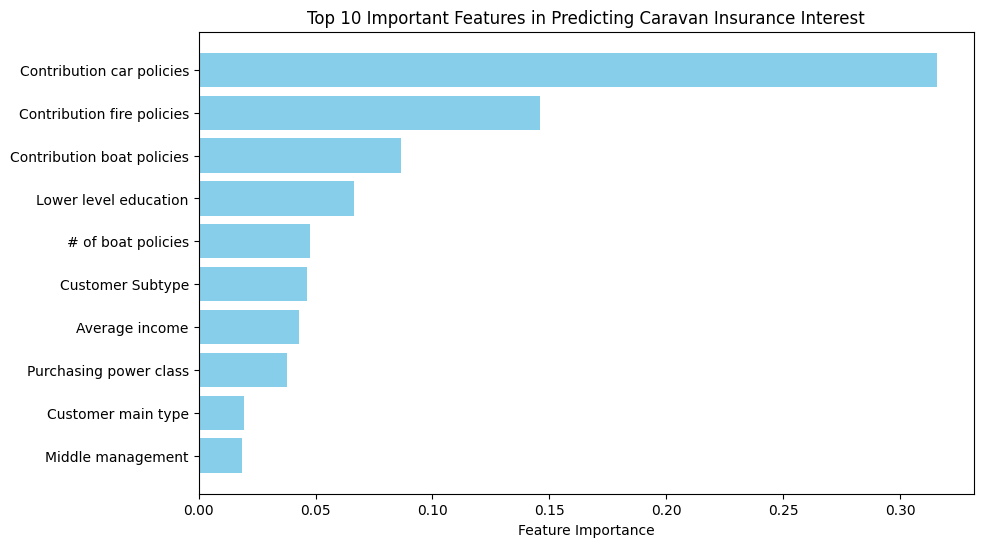

In [7]:
feature_importances = gb_final.feature_importances_
features = test.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(10)
print("Top 10 Features Influencing Decisions:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features in Predicting Caravan Insurance Interest')
plt.show()

## Feature Importance (Gradient Boosting)

- Gini importance measures how much each feature reduces impurity across all trees.  
- It is quick and widely used, but has some **biases**:
  - Favors variables with many unique values (more possible split points).  
  - Reflects splits in the training set, not necessarily the true predictive power on new data.  
- Despite these , it still provides a **useful global ranking** of which features the model relies on most.  
